In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df = pd.read_csv('healthcare-stroke-data.csv')
df['gender'] = (df['gender'] == 'Male') * 1.  # 1 Male | 0 Female
df['ever_married'] = (df['ever_married'] == 'Yes') * 1.0
df['residence_type'] = (df['Residence_type'] == 'Urban') * 1.0

df.drop(['Residence_type', 'id'], axis=1, inplace=True)
df_train, df_test = train_test_split(df, test_size=.25, random_state=26)
df_train, df_valid = train_test_split(df_train, test_size=.3, random_state=26)


In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,residence_type
0,1.0,67.0,0,1,1.0,Private,228.69,36.6,formerly smoked,1,1.0
1,0.0,61.0,0,0,1.0,Self-employed,202.21,NaN,never smoked,1,0.0
2,1.0,80.0,0,1,1.0,Private,105.92,32.5,never smoked,1,0.0
3,0.0,49.0,0,0,1.0,Private,171.23,34.4,smokes,1,1.0
4,0.0,79.0,1,0,1.0,Self-employed,174.12,24.0,never smoked,1,0.0


## Feature Engineering

In [4]:
df_train['bmi'] = df_train['bmi'].fillna(df_train['bmi'].median())

In [5]:
# Define bins based on medical guidelines (or distribution)
bins = [0, 100, 140, 200, float('inf')]
labels = ['Low', 'Normal', 'High', 'Very High']

# Create the binned feature
df_train['glucose_category'] = pd.cut(df_train['avg_glucose_level'], bins=bins, labels=labels)

df_train['glucose_age_ratio'] = df_train['avg_glucose_level'] / df['age']
df_train['glucose_age_ratio'] = df_train['avg_glucose_level'] * df['age']

# Create age bins
age_bins = [0, 40, 60, float('inf')]
age_labels = ['Young', 'Middle-aged', 'Elderly']
df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_labels)

# Combine glucose and age categories
df_train['glucose_age_interaction'] = df_train['glucose_category'].astype(str) + "_" + df_train['age_group'].astype(str)


# BMI =========================================== #
bmi_mean = df['bmi'].mean()
df_train['bmi_relative'] = df_train['bmi'] - bmi_mean

df_train['bmi_hypertension'] = df_train['bmi'] * df_train['hypertension']
df_train['bmi_heart_disease'] = df_train['bmi'] * df_train['heart_disease']

df_train['bmi_glucose_ratio'] = df_train['bmi'] / df_train['avg_glucose_level']
df_train['bmi_glucose_product'] = df_train['bmi'] * df_train['avg_glucose_level']

# Obesity risk increases with age, so combining these features may reveal hidden trends:
# A younger person with high BMI may have different stroke risk than an older person with the same BMI.
# bmi_age_product captures compounding effects of aging and obesity.
df_train['bmi_age_ratio'] = df_train['bmi'] / df_train['age']
df_train['bmi_age_product'] = df_train['bmi'] * df_train['age']


# smoking_status ================================ #
df_train['is_smoker'] = df_train['smoking_status'].apply(lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0)
df_train['smoking_age_interaction'] = df_train['age'] * df_train['is_smoker']
df_train['smoking_bmi_interaction'] = df_train['bmi'] * df_train['is_smoker']
df_train['bmi_diff_from_smoking_mean'] = df_train['bmi'] - df_train.groupby('smoking_status')['bmi'].transform('mean')

smoking_counts = df_train['smoking_status'].value_counts().to_dict()
df_train['smoking_status_freq'] = df_train['smoking_status'].map(smoking_counts)


smoking_agg = df_train.groupby('smoking_status')[['age', 'bmi', 'avg_glucose_level']].agg(['mean', 'std', 'median']).reset_index()
# Flatten multi-level columns
smoking_agg.columns = ['_'.join(col).strip() for col in smoking_agg.columns.values]
# Merge back with the original DataFrame
df_train = df_train.merge(smoking_agg, left_on='smoking_status', right_on='smoking_status_', how='left')


## Mutual Information

In [6]:
# Select features and target
X = df_train.drop('stroke', axis=1)
y = df_train['stroke']

# # Handle categorical features if needed (e.g., encoding)
# X = pd.get_dummies(X)

# # Compute mutual information
# mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Label encoding for categoricals
for colname in X.select_dtypes(['object', 'category']):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores.head(15)  # Potentially highest informative features


,MI Scores
age,0.040469
glucose_age_interaction,0.035819
age_group,0.033526
bmi_age_product,0.032786
bmi_age_ratio,0.027487
glucose_age_ratio,0.021888
bmi_hypertension,0.014918
work_type,0.009797
smoking_bmi_interaction,0.009692
bmi_relative,0.009301


In [7]:
# Potentially least informative features.
mi_scores.tail(10)

,MI Scores
is_smoker,0.000746
bmi_glucose_product,0.000324
bmi_std,0.000000
avg_glucose_level_std,0.000000
bmi_median,0.000000
gender,0.000000
age_std,0.000000
bmi_glucose_ratio,0.000000
avg_glucose_level,0.000000
avg_glucose_level_median,0.000000


In [8]:
""" simply just impute bmi; and go with the given features
Possible Next Steps:
1] Focus on high-MI features like age for further modeling or feature engineering.
2] Investigate zero-MI features: Are they truly uninformative, or could preprocessing (e.g., binning glucose levels) reveal patterns?
3] Consider feature interactions: Low-scoring individual features may still matter when combined with others (e.g., age + hypertension).
""";

In [9]:
"""
✅ New Features Add Value
glucose_age_interaction (0.0358) and age_group (0.0335) now rank just below age, meaning these features capture useful patterns.
glucose_age_ratio (0.0219) also provides additional information that was missing from the raw avg_glucose_level.
👉 Takeaway: Combining age and glucose reveals meaningful relationships that were hidden when these features were separate.
""";

In [10]:
""" Q: why would df['bmi_hypertension'] = df['bmi'] * df['hypertension']  be meaningful? hypertension is binary 0/1

Great question!
The interaction df['bmi_hypertension'] = df['bmi'] * df['hypertension'] can be meaningful
despite hypertension being a binary (0/1) variable.
Here's why:

✅ When Does This Help Most?
If BMI’s effect depends on hypertension status.
When the combination of BMI and hypertension is more predictive than either feature alone.
For tree-based models like Random Forest, which can split on interaction features and improve performance.
""";

## Ablation Study


In [11]:
"""
Here's a streamlined Ablation Study setup
to test the impact of age and age_group on model performance (using Random Forest and AUC-ROC).
""";

X1 = df_train.copy()

# Identify categorical columns (non-numeric features)
cat_cols = X1.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categorical features with OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)  # Handle unseen categories safely
X1[cat_cols] = encoder.fit_transform(X1[cat_cols])

# # Helper function to train and evaluate model
# def train_and_evaluate(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred_prob = model.predict_proba(X_test)[:, 1]
#     return roc_auc_score(y_test, y_pred_prob)

# Helper function: Train and evaluate with OOB for imbalanced data
def train_and_evaluate(X, y):
    model = RandomForestClassifier(
        n_estimators=100,
        oob_score=True,
        class_weight="balanced",  # Handle imbalance
        random_state=42
    )
    model.fit(X, y)
    auc_score = roc_auc_score(y, model.oob_decision_function_[:, 1])
    return round(auc_score, 4)

# Define your feature sets
y = X1["stroke"]
feature_sets = {
    "all_features": X1.drop(columns=["stroke"]),
    "age_only": X1.drop(columns=["stroke", "age_group"]),
    "age_group_only": X1.drop(columns=["stroke", "age"]),
    "no_age_features": X1.drop(columns=["stroke", "age", "age_group"]),
}

# Run the ablation study
results = {name: train_and_evaluate(X, y) for name, X in feature_sets.items()}
# for name, auc in results.items():
#     print(f"{name}: AUC-ROC = {auc:.4f}")

# Final comparison
df_results = pd.DataFrame(list(results.items()), columns=['features', 'score'])
df_results.sort_values(by='score', ascending=False).reset_index(drop=True)


,features,score
0,age_only,0.7740
1,all_features,0.7655
2,age_group_only,0.7592
3,no_age_features,0.7570


In [12]:
"""
This result suggests a few key insights:

Age (continuous) is slightly better than age_group (categorical):
- The age_only model (AUC = 0.7734) performs better than age_group_only (AUC = 0.7727).
- This indicates that keeping raw age provides more granular information, which the Random Forest can effectively leverage.

Including both age and age_group gives a small boost:
- The best performance comes from all_features (AUC = 0.7741), meaning there’s some complementary information when combining both representations.
- The gain is small, so keeping both features slightly improves the model but may not be essential.

Age features are important:
- Removing both (no_age_features with AUC = 0.7656) leads to the worst performance, confirming age-related variables are highly predictive.


💡 Recommendations:
- Keep both age and age_group for now—since they work well together and slightly boost performance.
- For simplification, you could drop age_group as it adds only a small gain and continuous age is more informative.
- Consider interaction terms (e.g., age * glucose) for future improvements, as these relationships might capture complex effects.
""";

## Univariate feature selection with F-test

In [13]:
cols_num = X.select_dtypes(include=['number']).columns.values.tolist()
cols_num

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'residence_type',
 'glucose_category',
 'glucose_age_ratio',
 'age_group',
 'glucose_age_interaction',
 'bmi_relative',
 'bmi_hypertension',
 'bmi_heart_disease',
 'bmi_glucose_ratio',
 'bmi_glucose_product',
 'bmi_age_ratio',
 'bmi_age_product',
 'is_smoker',
 'smoking_age_interaction',
 'smoking_bmi_interaction',
 'bmi_diff_from_smoking_mean',
 'smoking_status_freq',
 'smoking_status_',
 'age_mean',
 'age_std',
 'age_median',
 'bmi_mean',
 'bmi_std',
 'bmi_median',
 'avg_glucose_level_mean',
 'avg_glucose_level_std',
 'avg_glucose_level_median']

In [14]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html
selector = SelectKBest(f_classif, k=4)
selector.fit(X[cols_num], y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

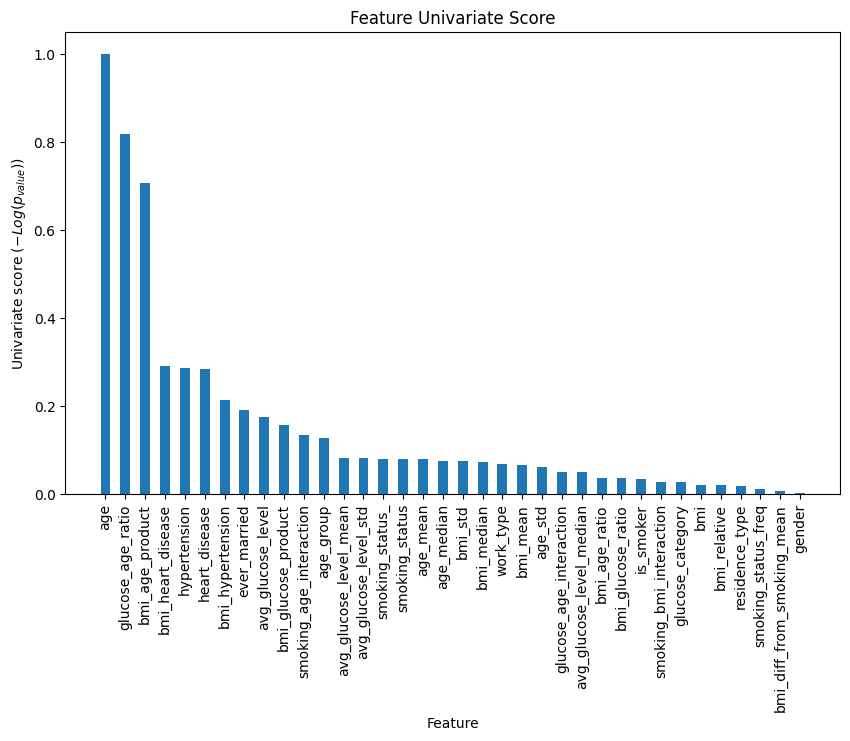

In [15]:
# Get feature indices
X_indices = np.arange(X[cols_num].shape[-1])

# Sort scores and corresponding feature names in descending order
sorted_indices = np.argsort(scores)[::-1]  # Sort indices by score (descending order)
sorted_scores = scores[sorted_indices]
sorted_features = np.array(cols_num)[sorted_indices]  # Reorder feature names

plt.figure(figsize=(10, 6))
plt.clf()
plt.bar(X_indices, sorted_scores, width=0.5)
plt.title("Feature Univariate Score")
plt.xlabel("Feature")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")

# Set sorted feature names as x-axis labels
plt.xticks(X_indices, sorted_features, rotation=90)

plt.show()


In [15]:
"""
📝 Notebook Summary:
In this notebook, we explored advanced feature engineering and selection techniques to enhance stroke prediction using a Random Forest model.
Key steps included:

Feature Engineering:
- Created interaction features (e.g., glucose_age_ratio, bmi_age_product).
- Generated group-based statistics (e.g., smoking_status mean and std aggregations).
- Applied binning strategies (e.g., age_group from continuous age).

Feature Selection:
- Mutual Information (MI) to capture non-linear relationships.
- F-Test (ANOVA) to identify linear dependencies.
- Evaluated feature subsets via model performance (ROC-AUC) to guide inclusion decisions.

Model Validation:
- Compared feature sets (e.g., age vs. age_group) through ROC-AUC.
- Used train-test split for reliable performance assessment (avoiding OOB due to class imbalance).

This workflow provides a comprehensive approach to improving model interpretability and predictive power
through thoughtful feature engineering and rigorous evaluation.
""";